In [1]:

import numpy as np
print('numpy: %s' % np.__version__) # print version

# Note need to 'pip install gym', and 'pip install gym[toy_text]' 
                                  # or 'pip install gym\[toy_text\]' if zsh does nor recongize the first command
import gym # for simulated environments
print('gym: %s' % gym.__version__) # print version

import matplotlib
import matplotlib.pyplot as plt # for displaying environment states
print('matplotlib: %s' % matplotlib.__version__) # print version

from IPython import display # for displaying environment states
import time # for slowing down rendering of states by adding small time delays

numpy: 1.23.2
gym: 0.26.2
matplotlib: 3.4.3


In [4]:

# Setup environment
env = gym.make(id='FrozenLake-v1', # Choose one of the existing environments
               desc=None, # Used to specify custom map for frozen lake. E.g., desc=["SFFF", "FHFH", "FFFH", "HFFG"].
               map_name='4x4', # ID to use any of the preloaded maps. E.g., '4x4', '8x8'
               is_slippery=False, # True/False. If True will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.
               max_episode_steps=None, # default=None, Maximum length of an episode (TimeLimit wrapper).
               autoreset=False, # default=None, Whether to automatically reset the environment after each episode (AutoResetWrapper).
               disable_env_checker=None, # default=None, If to run the env checker
               render_mode = 'rgb_array' # The set of supported modes varies per environment. (And some third-party environments may not support rendering at all.)
              )



In [5]:
# Show environment description (map) as an array
print("Environment Array: ")
print(env.desc)

# Observation and action space 
state_obs_space = env.observation_space # Returns sate(observation) space of the environment.
action_space = env.action_space # Returns action space of the environment.
print("State(Observation) space:", state_obs_space)
print("Action space:", action_space)

Environment Array: 
[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]
State(Observation) space: Discrete(16)
Action space: Discrete(4)


S = Start, F = Frozen, H = Hole, G = Goal.

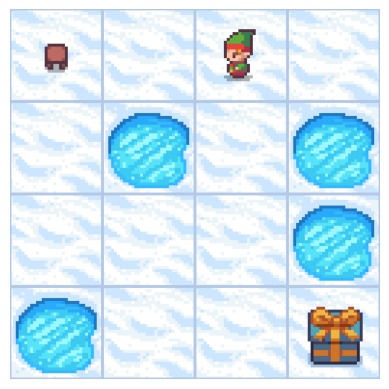

In [57]:
# Reset environment to initial state
state ,  info = env.reset()

# Cycle through 20 random steps rendering and displaying the agent inside the environment
for _ in range(20):
    # Render and display current state of the environment 
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) #  get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Sample a random action from the entire action space
    random_action = env.action_space.sample()
    
    # Pass the reandom action from the entire action space
    state , reward , done , _ , info = env.step(random_action)
    
    # Wait a little bit before the next frame
    time.sleep(0.2)
    
    # Reset environment when done = True i.e. , when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display current state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True)# clear output before showing the next frame 
        # Reset environment
        state , info = env.reset()

# Close environment
env.close()

# Training the Q-function to find the best policy

In [15]:
# Q-function parameters
alpha = 0.7 # lr
gamma = 0.95 # discount factor

# Training parameters
n_episodes = 10000 # number of episodes to use for training
n_max_steps = 100 # maximum number of steps per episode

# Exploration / Exploitation parameters
start_eplison = 1.0 # start training by selecting purely random actions
min_eplison = 0.05 # the lowest eplison allowed to decay to
decay_rate = 0.001 # eplison will gradually decay so we do less exploring and more exploiting  as Q-function improves

In [33]:
# Initial Q-table
# Our Q-table is a matrix of state(observation) space x action space , i.e. , 16x4
Qtable = np.zeros((env.observation_space.n , env.action_space.n))

# Show 
Qtable

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Recall that Q-Learning is an **off-policy** algorithm. hence , we will define one function for acting (epsilon_greedy) and another for **updating** the Q-table(update_Q). The updating policy uses a greedy approach , i.e. no exploration.

You should be able to spot that update_Q function contains the Q-Learning algorithm equation analysed in the previous section.

In [49]:
# This is our acting policy (epsilon-greedy) , for the agent to do exploitation during training
def epsilon_greedy(Qtable , state , epsilon):
    # Generate a random number and compare to epsilon , if lower than explore , otherwise exploit
    random = np.random.uniform(0,1)
    if random < epsilon:
        action = env.action_space.sample() # explore
    else:
        action = np.argmax(Qtable[state , :]) # exploit
    return action

# This is our updating policy (greedy)
# i.e. , always select the action with highest value for that state : np.max(Qtable[next_state])
def update_Q(Qtable,state , action , reward , next_state):
    # Q(S_t , A_t) = Q(S_t , A_t) + alpha[R_t+1+gamma * max Q(S_t+1 , a) - Q(S_t , A_t)]
    Qtable[state][action] = Qtable[state][action] + alpha*(reward + gamma * np.max(Qtable[next_state]) - Qtable[state][action])
    return Qtable

# This function (also greedy) will return the action from Qtable when we do evaluation
def eval_greedy(Qtable , state):
    action = np.argmax(Qtable[state,:])
    return action

In [50]:
np.exp?

In [51]:
def train(n_episodes , n_max_steps , start_epsilon,min_epsilon , decay_rate,Qtable):
    for episode in range(n_episodes):
        
        # Reset the environment at the start of each episode
        state , info = env.reset()
        t = 0
        done = False
        
        # Calculate epsilon value based on decay rate
        epsilon = max(min_epsilon , (start_eplison-min_epsilon))*np.exp(-decay_rate * episode)
        
        for t in  range(n_max_steps):
            # Choose an action using previously defined epsilon greedy policy
            action = epsilon_greedy(Qtable,state,epsilon)
            
            # Perform the action in the environment , get reward and next state
            next_state , reward , done , _ , info = env.step(action)
            
            # Update Q-table
            Qtable = update_Q(Qtable , state ,action,reward,next_state)
            
            # Update current state
            state = next_state
            
            # Fininsh the epsoide when done=True i.e reached the goal or fallen into a hole
            if done:
                break

# Return final Q-table        
    return Qtable    

In [52]:
Qtable = train(n_episodes , n_max_steps , start_eplison , min_eplison , decay_rate,Qtable)

# show optimised Q-table
Qtable

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378053, 0.7737809 ],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

 # Evaluation
-  Let's evaluate this policy by running a few simulations and checking if the agent always manages to get the maximum reward

In [53]:
def evaluate_agent(n_max_steps , n_eval_episodes,Qtable):
    # Initialize an empty list to store rewards for each episode
    episode_rewards = []
    
    # Evaluate for each episode
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each
        state , info = env.reset()
        t = 0
        done = False
        tot_episode_reward = 0
        
        for t in range(n_max_steps):
            # Use greedy policy to evaluate
            action = eval_greedy(Qtable , state)
            
            # Pass action into step function
            next_state , reward , done , _ , info = env.step(action)
            
            # sum episode rewards
            tot_episode_reward +=reward
            
            # update current state
            state = next_state
            
            # Finish
            if done:
                break
        episode_rewards.append(tot_episode_reward)
    mean_rewards = np.mean(episode_rewards)
    std_rewards = np.std(episode_rewards)
    
    return mean_rewards , std_rewards

n_eval_episodes = 100 # evaluate over 100 episodes
mean_rewards , std_rewards = evaluate_agent(n_max_steps , n_eval_episodes,Qtable)
print(f"Mean Reward = {mean_rewards:.2f} +/- {std_rewards : .2f}")

Mean Reward = 1.00 +/-  0.00


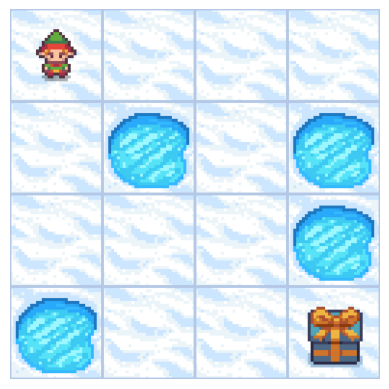

In [56]:
# Cycle through 19 steps rendering and displaying environment state each time
state , info = env.reset()
for _ in range(19):
    
    plt.imshow(env.render())
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action = eval_greedy(Qtable,state)
    
    # pass action into function step
    state,reward , done,_,info = env.step(action)
    
    time.sleep(0.2)
    
    if done:
        plt.imshow(env.render())
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state , info = env.reset()
env.close()